In [22]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))
sys.path.insert(0,os.path.dirname(os.path.abspath("")))
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import ecdf
from molNet.featurizer import normalization
from inspect import isfunction,getsource
from scipy.optimize import curve_fit
import cdf_h
import json
from numpy.linalg import LinAlgError

['/home/julian/IdeaProjects/molNet', '/home/julian/IdeaProjects/molNet', '/home/julian/IdeaProjects/molNet', '/home/julian/IdeaProjects/molNet/tools', '/home/julian/anaconda3/envs/graph_chem_unit/lib/python38.zip', '/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8', '/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/lib-dynload', '', '/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages', '/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/IPython/extensions', '/home/julian/.ipython', '/home/julian/IdeaProjects/molNet', '/home/julian/IdeaProjects/molNet', '/home/julian/IdeaProjects/molNet']


In [23]:
norm_functions={}
for f in dir(normalization):
    func = getattr(normalization,f)
    if isfunction(func) and "norm" in func.__name__:
        norm_functions[func.__name__]=func
        print(getsource(func))

#del norm_functions['genlog_norm']
norm_functions

def dual_sig_norm(x, m: float = 0, d1: float = 1, d2: float = 1):
    li = x <= m
    # mx = np.argmin(np.abs(x - m))
    return np.concatenate((sig_norm(x[li], m=m, d=d1), sig_norm(x[~li], m=m, d=d2)))

def genlog_norm(x, B, M, Q, v):
    # B=growth rate (-np.inf,np.inf)
    # M=shifts horizontally (-np.inf,np.inf)
    # Q=urvibess/stepness (0,np.inf)
    # v=stepness (1e-12,np.inf)
    return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)

def linear_norm(x, m: float = 1, c: float = 0):
    return x * m + c

def min_max_norm(x, min: float = 0, max: float = 1):
    # if min>max:
    #    max,min=min,max
    # if min == max:
    #    max*= 1+1e-6
    return np.clip(linear_norm(x, m=1 / (max - min), c=-min / (max - min)), 0, 1)

def sig_norm(x, m: float = 0, d: float = 1):
    return 1 / (1 + np.exp(-d * (x - m)))



{'dual_sig_norm': <function molNet.featurizer.normalization.dual_sig_norm(x, m: float = 0, d1: float = 1, d2: float = 1)>,
 'genlog_norm': <function molNet.featurizer.normalization.genlog_norm(x, B, M, Q, v)>,
 'linear_norm': <function molNet.featurizer.normalization.linear_norm(x, m: float = 1, c: float = 0)>,
 'min_max_norm': <function molNet.featurizer.normalization.min_max_norm(x, min: float = 0, max: float = 1)>,
 'sig_norm': <function molNet.featurizer.normalization.sig_norm(x, m: float = 0, d: float = 1)>}

In [24]:
def norm(f,x,y):
    opts=[]
    for lims in [(0,1),(0.001,0.999)]:
        for method in [None,'dogbox']:
            try:
                lim=(y>=lims[0]) & (y<=lims[1])
                bounds=(-np.inf, np.inf)
                p0=None
                if norm_functions['min_max_norm'] == f:
                    bounds=(x.min(),x.max())
                    p0= [x[lim].min(),x[lim].max()]
                if norm_functions['genlog_norm'] == f:
                    bounds=([1e-32,-np.inf,0,1e-12],[np.inf,np.inf,np.inf,np.inf])

            
                popt, pcov = curve_fit(f, x[lim],y[lim], method=method,p0=p0,bounds=bounds)

                r=np.sqrt(((f(x[lim],*popt)-y[lim])**2).mean())
                if np.isnan(r):
                    raise ValueError("r is infinite")
                opts.append((popt,r,lims,method))
            except (RuntimeError,ValueError,TypeError,LinAlgError)as e:
                print(e)
                pass
            except (IndexError,) as e:
                print(x)
                raise e
    
    
    #print(opts)
    if len(opts)>0:
        opts = sorted(opts,key= lambda d:d[1])
        return opts[0]
    return None,None
    
def read_file(file,plot=True):
    ecdf_file=file[:-5]+".ecdf"
    ifn=file[:-5]+".png"
    if not os.path.exists(ifn):
        plot=True
    if os.path.exists(ecdf_file):
        with open(ecdf_file,"rb") as f:
            necdf_data1,necdf_data2=pickle.load(f)
    else:
        plot=True
        with open(file,"rb") as f:
            data=pickle.load(f)
        ecdres=1000
        if len(data["data"])==0:
            return
        necdf_data1=ecdf.ecdf(data["data"],res=ecdres)
        necdf_data2=ecdf.ecdf(data["data"],res=ecdres,smooth=True,unique_only=True)#
        with open(ecdf_file,"w+b") as f:
            pickle.dump((necdf_data1,necdf_data2),f)
    necdf1_x=[]
    necdf1_y=[]
    necdf2_x=[]
    necdf2_y=[]
    if isinstance(necdf_data1,tuple):
        necdf1_x.append(necdf_data1[0])
        necdf1_y.append(necdf_data1[1])
    else:
        for d in necdf_data1:
            necdf1_x.append(d[0])
            necdf1_y.append(d[1])

    if isinstance(necdf_data2,tuple):
        necdf2_x.append(necdf_data2[0])
        necdf2_y.append(necdf_data2[1])
    else:
        for d in necdf_data2:
            necdf2_x.append(d[0])
            necdf2_y.append(d[1])
    
    data_file=file[:-5]+".data"
    reg_data={}
    if os.path.exists(data_file):
        with open(data_file,"r") as f:
            reg_data=json.load(f)
    change=False
    if plot:
        fig,axs = plt.subplots(1,2,figsize=(10,5))
    for n,f in norm_functions.items():
        if n in reg_data:
            print("cahnge due to function name in reg data")
            change=True
            reg_data[str(0)]=reg_data[n]
            del reg_data[n]
    for i in range(len(necdf1_x)):
        
#        print(necdf2_x[i])
#        print(necdf2_y[i])
        if str(i) not in reg_data:
            reg_data[str(i)]={}
            change=True
            print("change due to number not in reg data")
        
        reg_datai=reg_data[str(i)]
        x_p=np.linspace(necdf2_x[i].min(),necdf2_x[i].max(),200)
        for n,f in norm_functions.items():
            if n in reg_datai:
                if plot:
                    for ax in axs:
                        ax.plot(x_p,f(x_p,*reg_datai[n]['parameter']),label=f"{n},R={reg_datai[n]['error']}")
            else:
                
                print(n)
                res =norm(f,necdf2_x[i],necdf2_y[i])
                popt,r=res[0],res[1]
                if r is not None:
                    #print(popt,r)
                    if plot:
                        for ax in axs:
                            ax.plot(necdf2_x[i],f(necdf2_x[i],*popt),label=f"{n},R={r}")
                    reg_datai[n]={"parameter":list(popt),
                                "error":r,
                                }
                    change=True
                    print("change due to reg not in reg data")
                    
            if n in reg_datai:
                if not "sample_bounds" in reg_datai[n] or change:
                    change=True
                    print("change due to sample_bounds not in reg data")
                    dp = f(necdf2_x[i],*reg_datai[n]['parameter'])
                    amin=necdf2_x[i].argmin()
                    amax=necdf2_x[i].argmax()
                    reg_datai[n]["sample_bounds"]=[
                        [
                            necdf2_x[i][amin],
                            necdf2_x[i][amax],
                        ],[
                            dp[amin],
                            dp[amax],
                        ]
                    ]
                if not "sample_bounds99" in reg_datai[n] or change:
                    
                    lim=(necdf2_y[i]>=0.01) & (necdf2_y[i]<=0.99)
                    if lim.sum() > 0:
                        dp = f(necdf2_x[i][lim],*reg_datai[n]['parameter'])
                        amin=necdf2_x[i][lim].argmin()
                        amax=necdf2_x[i][lim].argmax()
                        reg_datai[n]["sample_bounds99"]=[
                            [
                                necdf2_x[i][amin],
                                necdf2_x[i][amax],
                            ],[
                                dp[amin],
                                dp[amax],
                            ]
                        ]
                        print("change due to sample_bounds99 not in reg data")
                        change=True
        if plot:  
            for ax in axs:
                ax.plot(necdf1_x[i],necdf1_y[i],label="step ecdf")
                ax.plot(necdf2_x[i],necdf2_y[i],label="smooth ecdf")


            plt.title(file)
            plt.legend()
            for ax in axs:
                ax.set_ylim(-0.1,1.1)

            xmin=np.inf
            xmax=-np.inf
            for i,xa in enumerate(necdf2_x):
                ya = necdf2_y[i]
                if len(ya)>1 and (ya[1])>0.01:
                    xmin = min(xmin,xa.min())
                elif (ya>=0.01).any():
                    xmin = min(xmin,xa[ya>=0.01].min())
                else:
                    xmin = min(xmin,xa.min())
                if (ya<=0.99).any():
                    xmax = max(xmax,xa[ya<=0.99].max())
                else:
                    xmax = max(xmax,xa.max())
            d=0.1*(xmax-xmin)
            #print(xmin,xmax)
            axs[1].set_xlim(xmin-d,xmax+d)
            
            if not os.path.exists(ifn) or change:
                plt.savefig(ifn,dpi=200)
            plt.show()
            plt.close()
        
    
    if change:
        with open(data_file,"w+") as f:
            json.dump(reg_data,f, indent=4)
        

334
Asphericity_Featurizer.pckl
BCUT2D_CHGHI_Featurizer.pckl
BCUT2D_CHGLO_Featurizer.pckl
BCUT2D_LOGPHI_Featurizer.pckl
BCUT2D_LOGPLOW_Featurizer.pckl
BCUT2D_MRHI_Featurizer.pckl
BCUT2D_MRLOW_Featurizer.pckl
BCUT2D_MWHI_Featurizer.pckl
BCUT2D_MWLOW_Featurizer.pckl
BalabanJ_Featurizer.pckl
BertzCT_Featurizer.pckl
Chi0_Featurizer.pckl
Chi0n_Featurizer.pckl
Chi0v_Featurizer.pckl
Chi1_Featurizer.pckl
Chi1n_Featurizer.pckl
Chi1v_Featurizer.pckl
Chi2n_Featurizer.pckl
Chi2v_Featurizer.pckl
Chi3n_Featurizer.pckl
Chi3v_Featurizer.pckl
Chi4n_Featurizer.pckl
Chi4v_Featurizer.pckl
EState_VSA10_Featurizer.pckl
EState_VSA11_Featurizer.pckl
EState_VSA1_Featurizer.pckl
EState_VSA2_Featurizer.pckl
EState_VSA3_Featurizer.pckl
EState_VSA4_Featurizer.pckl
EState_VSA5_Featurizer.pckl
EState_VSA6_Featurizer.pckl
EState_VSA7_Featurizer.pckl
EState_VSA8_Featurizer.pckl
EState_VSA9_Featurizer.pckl
Eccentricity_Featurizer.pckl
ExactMolWt_Featurizer.pckl
FpDensityMorgan1_Featurizer.pckl
FpDensityMorgan2_Featuriz

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


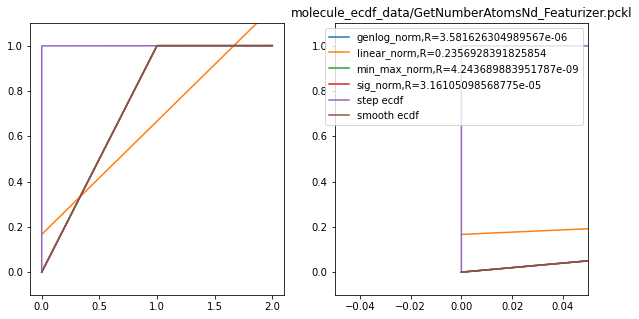

GetNumberAtomsNe_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


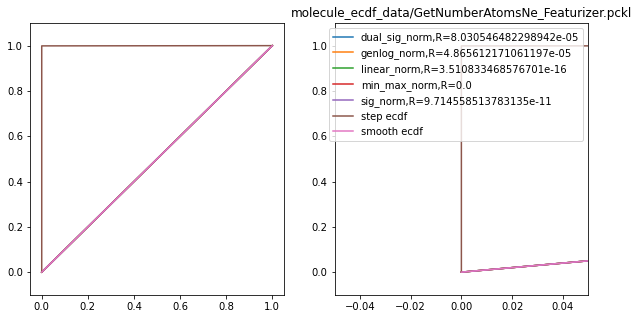

GetNumberAtomsNh_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

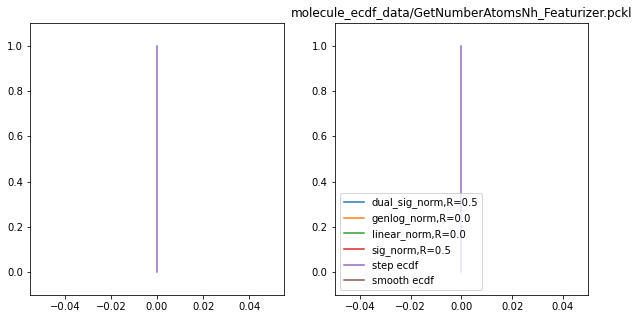

GetNumberAtomsNi_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg dat

<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


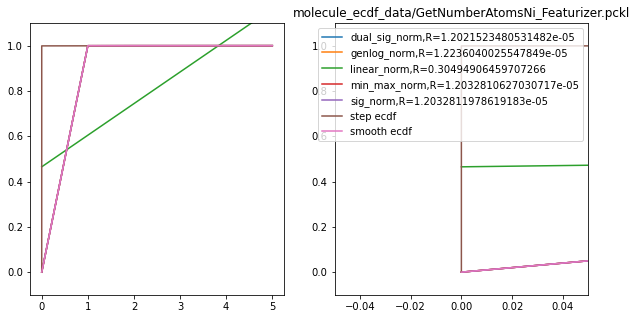

GetNumberAtomsNo_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

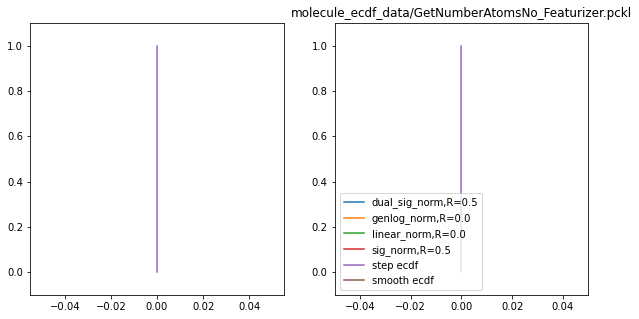

GetNumberAtomsNp_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

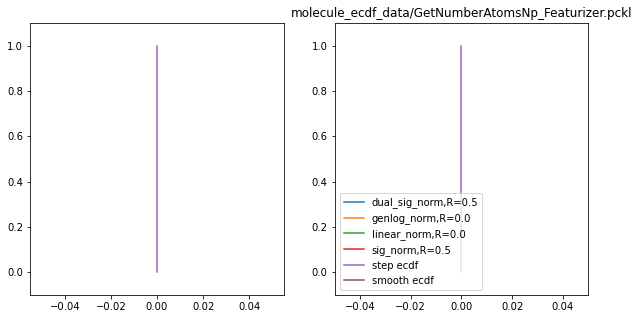

GetNumberAtomsO_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
genlog_norm


/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
linear_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
min_max_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
sig_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data


/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  return np.clip(linear_norm(x, m=1 / (max - min), c=-min / (max - min)), 0, 1)
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.clip(linear_norm(x, m=1 / (max - min), c=-min / (max - min)), 0, 1)
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:5: RuntimeWarning: invalid value encountered in multiply
  return x * m + c


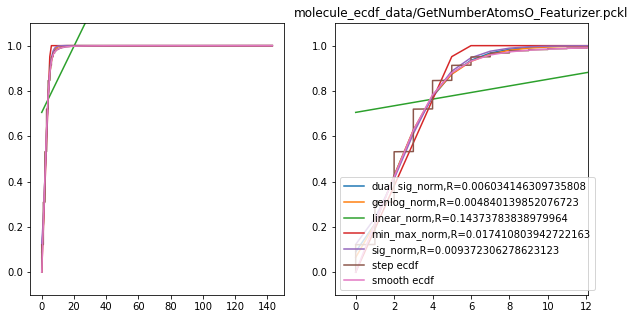

GetNumberAtomsOg_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

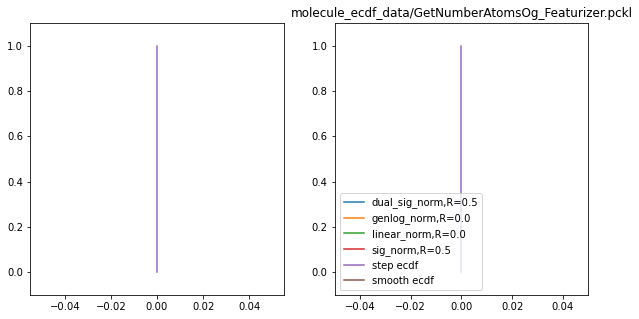

GetNumberAtomsOs_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


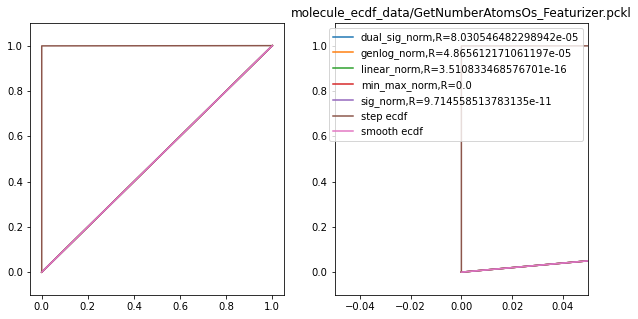

GetNumberAtomsP_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Optimal parameters not found: The maximum number of function evaluations is exceeded.
The number of func parameters=3 must not exceed the number of data points=2
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
change due to reg not in reg data
change due to sample_bounds not in reg data


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  return np.clip(linear_norm(x, m=1 / (max - min), c=-min / (max - min)), 0, 1)
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.clip(linear_norm(x, m=1 / (max - min), c=-min / (max - min)), 0, 1)
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:5: RuntimeWarning: in

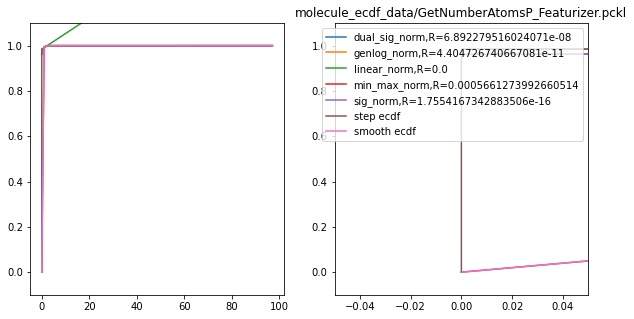

GetNumberAtomsPa_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


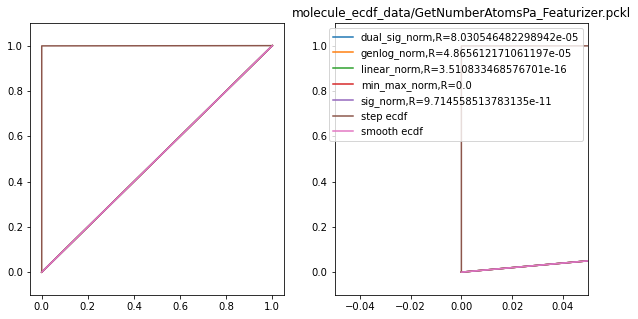

GetNumberAtomsPb_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


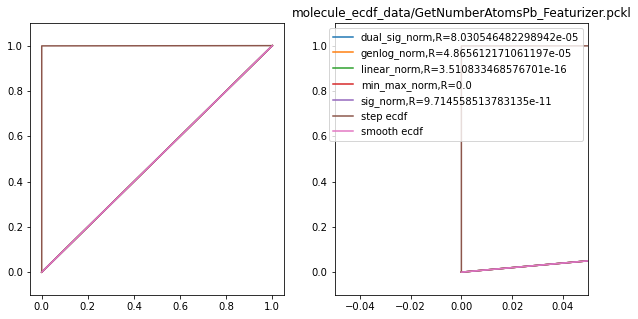

GetNumberAtomsPd_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


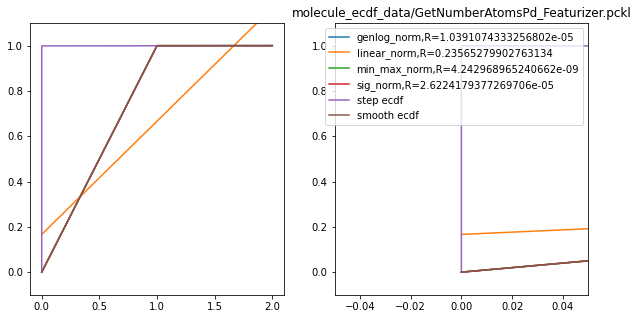

GetNumberAtomsPm_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

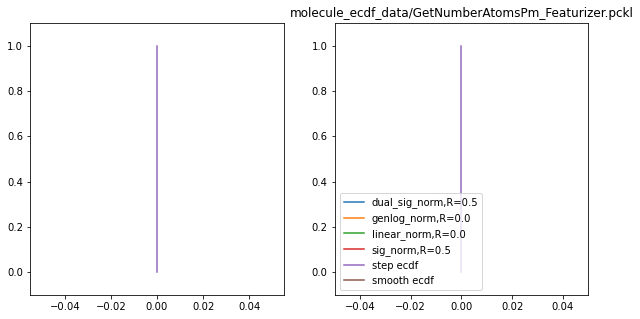

GetNumberAtomsPo_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


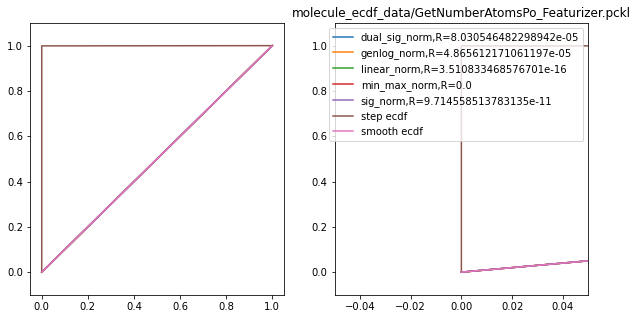

GetNumberAtomsPr_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

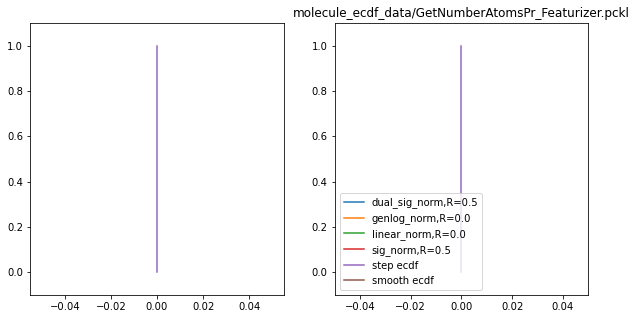

GetNumberAtomsPt_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


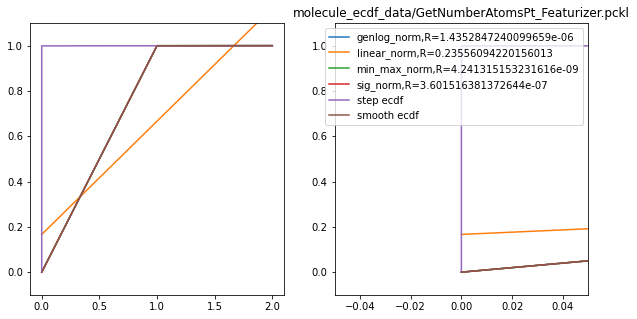

GetNumberAtomsPu_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

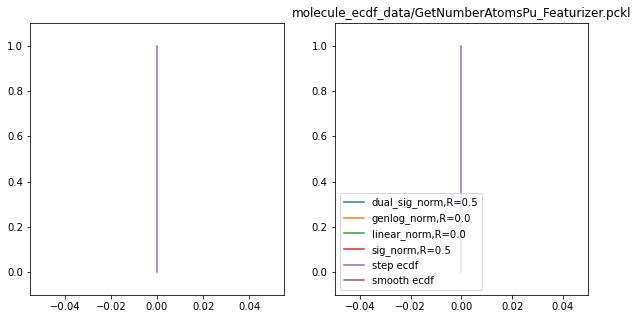

GetNumberAtomsRa_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

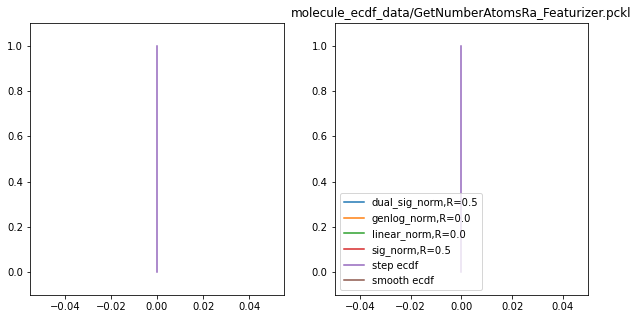

GetNumberAtomsRb_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages

change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


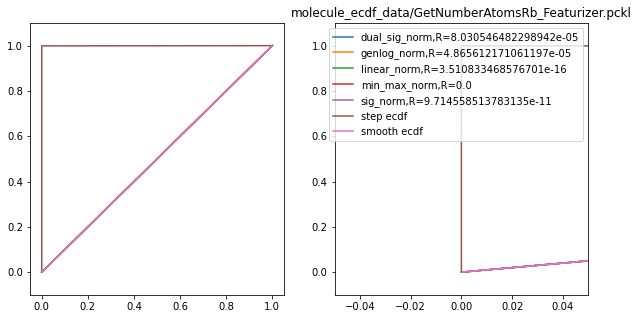

GetNumberAtomsRe_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages

`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


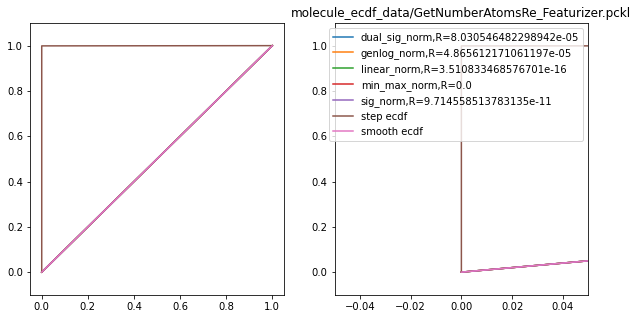

GetNumberAtomsRf_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
The number of func parameters=3 must not exceed the number of data points=2
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages

`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


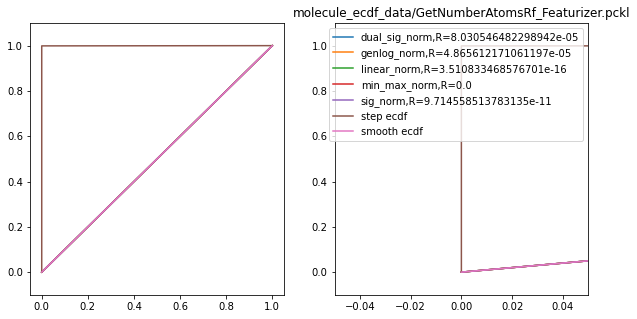

GetNumberAtomsRg_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

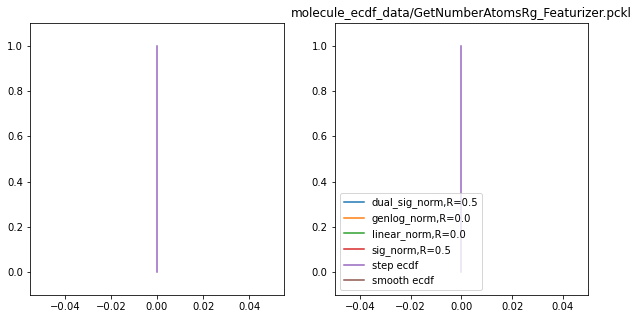

GetNumberAtomsRh_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


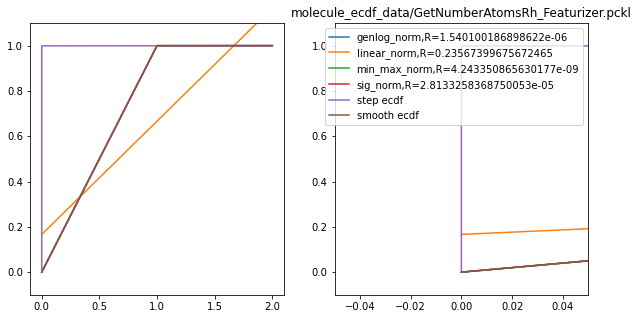

GetNumberAtomsRn_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Improper input: func input vector length N=3 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
Improper input: func input vector length N=2 must not exceed func output vector length M=1
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
sig_norm
Improper input: func input vec

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-24-710f61a91a

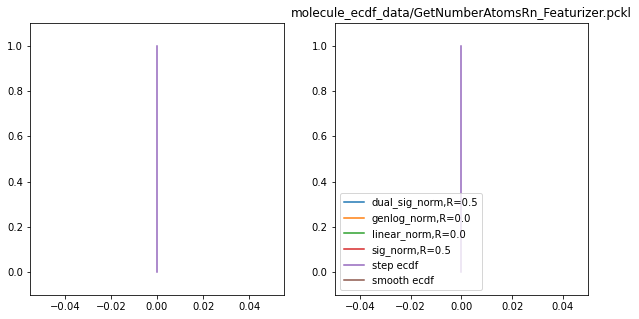

GetNumberAtomsRu_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
genlog_norm


/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data


<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


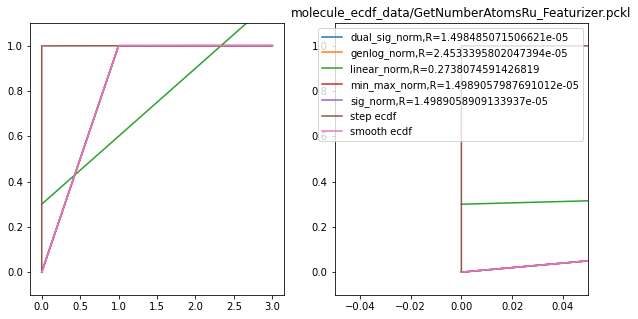

GetNumberAtomsS_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
genlog_norm


/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
linear_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
min_max_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data
sig_norm
change due to reg not in reg data
change due to sample_bounds not in reg data
change due to sample_bounds99 not in reg data


/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  return np.clip(linear_norm(x, m=1 / (max - min), c=-min / (max - min)), 0, 1)
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.clip(linear_norm(x, m=1 / (max - min), c=-min / (max - min)), 0, 1)
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:5: RuntimeWarning: invalid value encountered in multiply
  return x * m + c


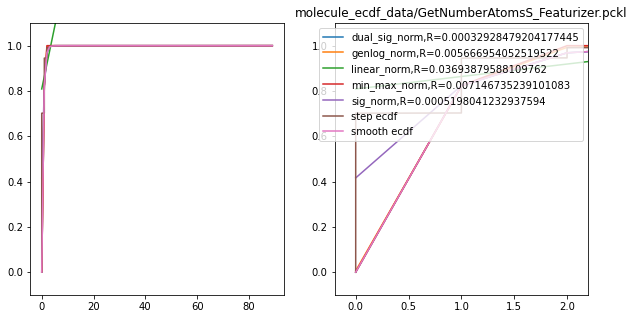

GetNumberAtomsSb_Featurizer.pckl
change due to number not in reg data
dual_sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
`ydata` must not be empty!
`ydata` must not be empty!
genlog_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
linear_norm
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg data
change due to sample_bounds not in reg data
min_max_norm
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
change due to reg not in reg data
change due to sample_bounds not in reg data
sig_norm
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
`ydata` must not be empty!
`ydata` must not be empty!
change due to reg not in reg

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
<ipython-input-24-710f61a91aa6>:182: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


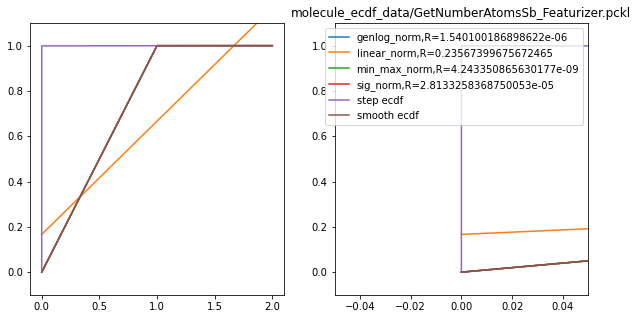

GetSSSR_Featurizer.pckl
HallKierAlpha_Featurizer.pckl
HeavyAtomCount_Featurizer.pckl
HeavyAtomMolWt_Featurizer.pckl
InertialShapeFactor_Featurizer.pckl
Ipc_Featurizer.pckl
Kappa1_Featurizer.pckl
Kappa2_Featurizer.pckl
Kappa3_Featurizer.pckl
LabuteASA_Featurizer.pckl
MaxAbsEStateIndex_Featurizer.pckl
MaxAbsPartialCharge_Featurizer.pckl
MaxEStateIndex_Featurizer.pckl
MaxPartialCharge_Featurizer.pckl
MinAbsEStateIndex_Featurizer.pckl
MinAbsPartialCharge_Featurizer.pckl
MinEStateIndex_Featurizer.pckl
MinPartialCharge_Featurizer.pckl
MolLogP_Featurizer.pckl
MolMR_Featurizer.pckl
MolWt_Featurizer.pckl
NHOHCount_Featurizer.pckl
NOCount_Featurizer.pckl
NPR1_Featurizer.pckl
NPR2_Featurizer.pckl
NumAliphaticCarbocycles_Featurizer.pckl
NumAliphaticHeterocycles_Featurizer.pckl
NumAliphaticRings_Featurizer.pckl
NumAmideBonds_Featurizer.pckl
NumAromaticCarbocycles_Featurizer.pckl
NumAromaticHeterocycles_Featurizer.pckl
NumAromaticRings_Featurizer.pckl
NumAtomsFeaturizer.pckl
NumAtoms_Featurizer.pckl

/home/julian/anaconda3/envs/graph_chem_unit/lib/python3.8/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


Optimal parameters not found: The maximum number of function evaluations is exceeded.


/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:29: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SlogP_VSA3_Featurizer.pckl
SlogP_VSA4_Featurizer.pckl
SlogP_VSA5_Featurizer.pckl
SlogP_VSA6_Featurizer.pckl
SlogP_VSA7_Featurizer.pckl
SlogP_VSA8_Featurizer.pckl
SlogP_VSA9_Featurizer.pckl
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
SpherocityIndex_Featurizer.pckl
TPSA_Featurizer.pckl
VSA_EState10_Featurizer.pckl
VSA_EState1_Featurizer.pckl
VSA_EState2_Featurizer.pckl
VSA_EState3_Featurizer.pckl
VSA_EState4_Featurizer.pckl
VSA_EState5_Featurizer.pckl
VSA_EState6_Featurizer.pckl
VSA_EState7_Featurizer.pckl


In [25]:
data_folder="molecule_ecdf_data"
files=[f for f in os.listdir(data_folder)  if f.endswith("Featurizer.pckl")]
print(len(files))
for f in sorted(files):
    print(f)
    read_file(os.path.join(data_folder,f),plot=False)

41
ExplicitValence_Featurizer.pckl
0.0 4.0


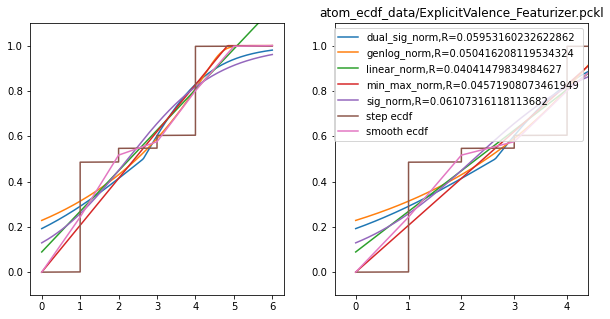

BCUT2D_MRLOW_Featurizer.pckl
AtomIsInRingFeaturizer.pckl
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


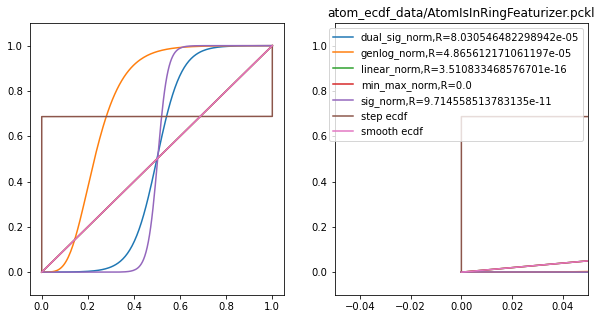

AtomPartialChargeFeaturizer.pckl
-0.476033091545105 0.3064815402030945


/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:31: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)
/home/julian/IdeaProjects/molNet/molNet/featurizer/normalization.py:31: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(1 / (1 + Q * np.exp(-B * (x - M))) ** (1 / v), nan=np.nan)


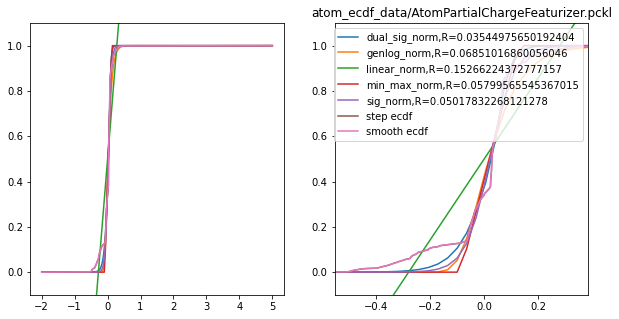

NumImplicitHs_Featurizer.pckl
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
[]
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


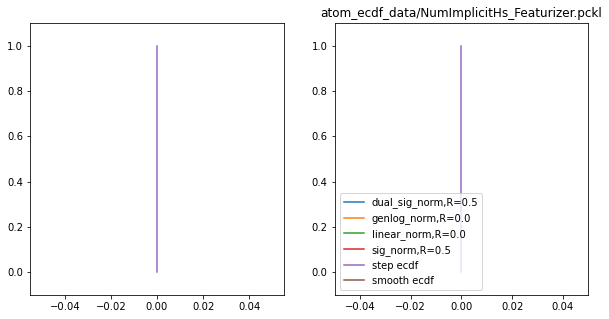

NumRadicalElectrons_Featurizer.pckl


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


0.0 0.0


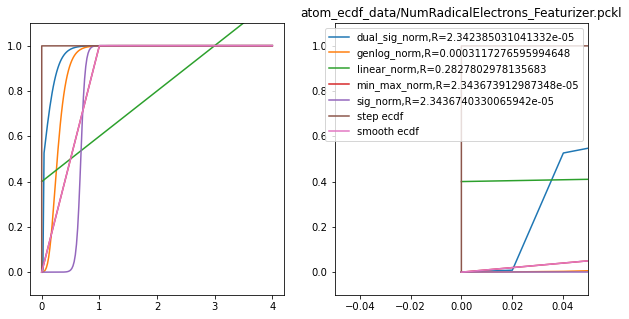

BCUT2D_MRHI_Featurizer.pckl
AtomPairAtomCode_Featurizer.pckl
36.0 481.0


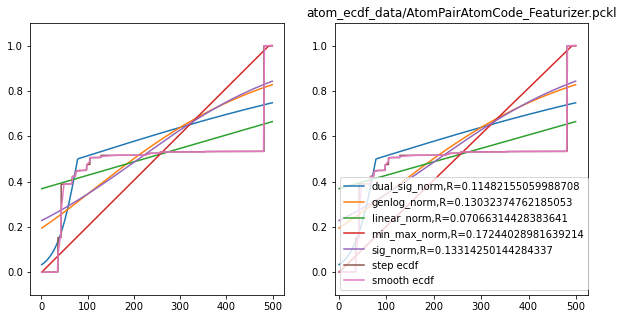

BCUT2D_LOGPLOW_Featurizer.pckl
Isotope_Featurizer.pckl
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


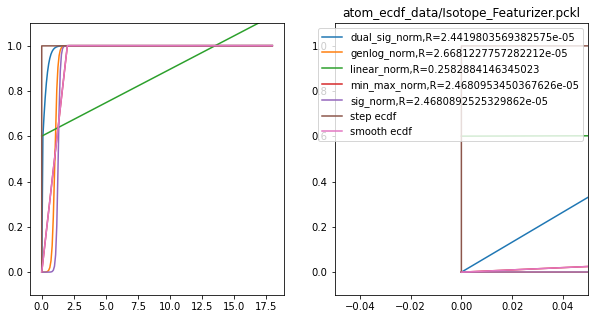

BCUT2D_CHGHI_Featurizer.pckl
AtomTotalNumHsFeaturizer.pckl
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
[]
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


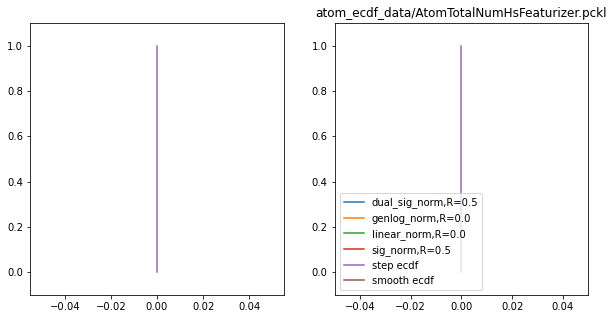

ImplicitValence_Featurizer.pckl


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
[]
0.0 0.0


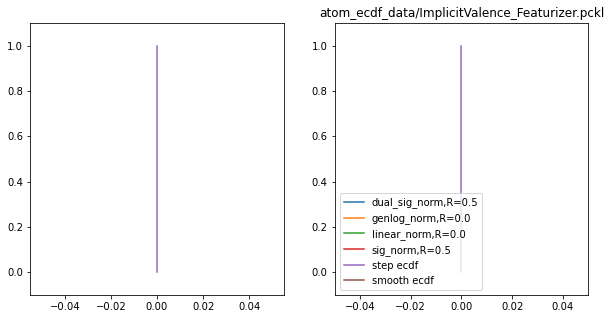

AtomFromalChargeFeaturizer.pckl


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


0.0 0.0


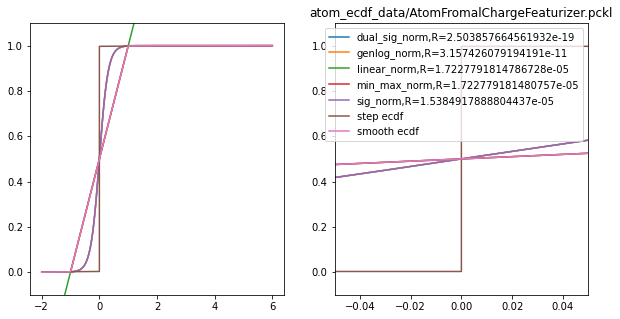

AtomExplicitValenceFeaturizer.pckl
0.0 4.0


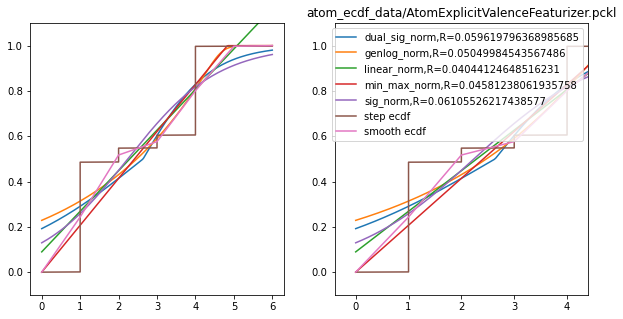

NumExplicitHs_Featurizer.pckl
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
[]
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


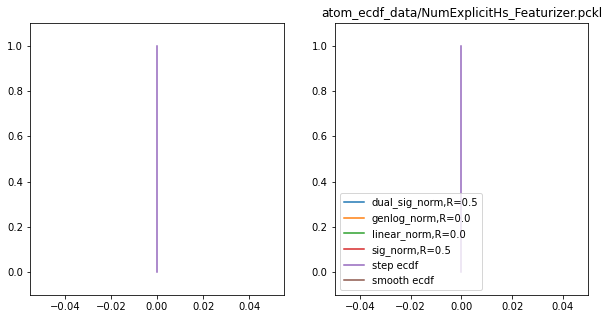

TotalNumHs_Featurizer.pckl
min_max_norm
Each lower bound must be strictly less than each upper bound.
Each lower bound must be strictly less than each upper bound.
zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
[]
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


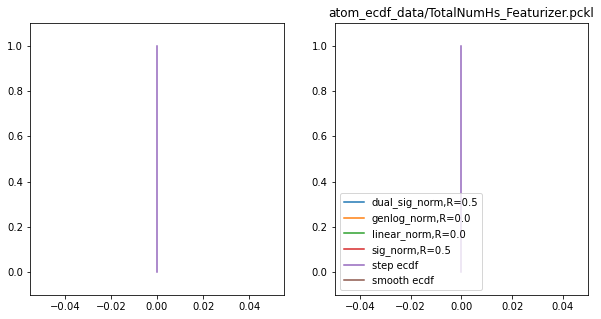

Mass_Featurizer.pckl
1.0080000162124634 32.06700134277344


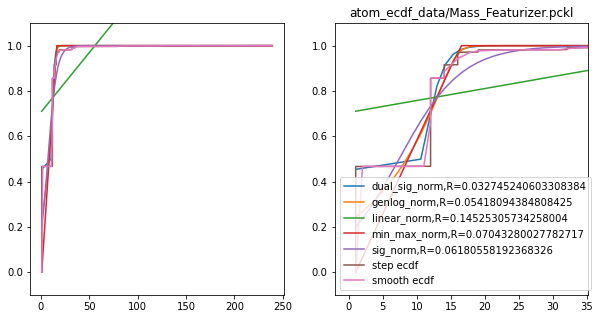

AtomIsAromaticFeaturizer.pckl
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


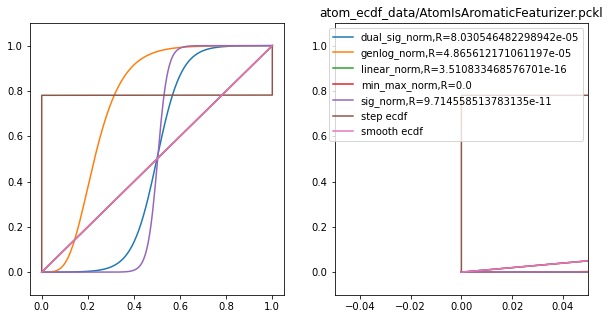

IsInRing_Featurizer.pckl
0.0 0.0


<ipython-input-8-61a463a1fd5c>:169: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  axs[1].set_xlim(xmin-d,xmax+d)


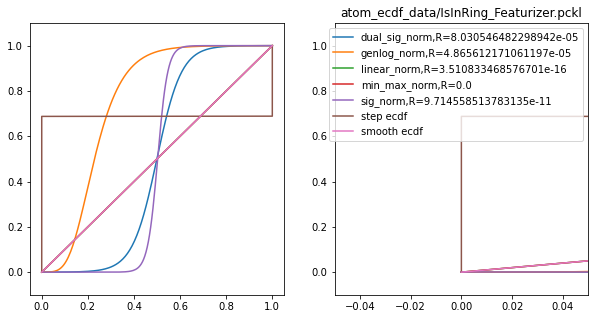

In [ ]:
data_folder="atom_ecdf_data"
files=[f for f in os.listdir(data_folder)  if f.endswith("Featurizer.pckl")]
print(len(files))
for f in files:
    print(f)
    read_file(os.path.join(data_folder,f))

In [10]:
print(cdf_h.generate_code_inject("AtomExplicitValenceFeaturizer",data_folder="atom_ecdf_data"))

    linear_norm_parameter = (0.1791769916807664, 0.08952095202325938)  # error of 4.04E-02 with sample range (0.00E+00,6.00E+00) resulting in fit range (8.95E-02,1.16E+00)
    min_max_norm_parameter = (0.0, 4.830304371104978)  # error of 4.58E-02 with sample range (0.00E+00,6.00E+00) resulting in fit range (0.00E+00,1.00E+00)
    sigmoidal_norm_parameter = (2.2382316379170075, 0.8510488834358428)  # error of 6.11E-02 with sample range (0.00E+00,6.00E+00) resulting in fit range (1.30E-01,9.61E-01)
    dual_sigmoidal_norm_parameter = (2.638598650893424, 0.5443631547021369, 1.16088033616735)  # error of 5.96E-02 with sample range (0.00E+00,6.00E+00) resulting in fit range (1.92E-01,9.80E-01)
    genlog_norm_parameter = (7.1738117035019355, 4.472858909381841, 4.007217082592335, 22.69092563871108)  # error of 5.05E-02 with sample range (0.00E+00,6.00E+00) resulting in fit range (2.29E-01,1.00E+00)
    preferred_normalization = 'linear'


In [23]:
from molNet.featurizer.molecule_featurizer import _available_featurizer
vars(_available_featurizer['molecule_fr_Imine'])

{'_length': 1,
 '_feature_descriptions': None,
 '_add_prefeat': None,
 '_linear_norm_parameter': (0.03889649931506156, 0.9186823185913269),
 '_min_max_norm_parameter': (5.062601797035858e-09, 1.0443004597486796),
 '_sigmoidal_norm_parameter': (-0.23305480673382584, 2.52767371071209),
 '_dual_sigmoidal_norm_parameter': (-0.23305480786468896,
  1.0,
  2.5276737069674944),
 '_genlog_norm_parameter': (2.54376914192436,
  0.4607687831175127,
  0.31984182613502987,
  1.7997417746060027),
 '_norm_map': {None: <bound method NormalizationClass.unity_norm of fr_Imine_Featurizer>,
  'None': <bound method NormalizationClass.unity_norm of fr_Imine_Featurizer>,
  'unity': <bound method NormalizationClass.unity_norm of fr_Imine_Featurizer>,
  'linear': <bound method NormalizationClass.linear_norm of fr_Imine_Featurizer>,
  'min_max': <bound method NormalizationClass.min_max_norm of fr_Imine_Featurizer>,
  'sig': <bound method NormalizationClass.sig_norm of fr_Imine_Featurizer>,
  'dual_sig': <bound m

In [101]:
t=0
k=10
e=1e19
tgt =np.zeros(k)
tgt[t]=1

c = np.zeros(k)#+np.random.rand(k)/e
c[t]+=1
#c=c/c.sum()

(c,
-c[t]+np.log(np.sum(np.exp(c))),
 
np.sum(np.log(c+1e-12)*(-tgt)) + np.sum(np.log((1-c)+1e-12)*((1-tgt)))
)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 1.461150171734475,
 8.000711204654728e-12)